In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm # to build a LOWESS model
lowess = sm.nonparametric.lowess

import numpy as np
import matplotlib.dates as mdates
from matplotlib import gridspec
import matplotlib as mpl
import matplotlib

def error_lowess_filter(error, speed, time, frac=None):
        print('Calculating errors and lowess function')
        error_val = np.delete(error, np.argwhere(np.isnan(speed.values)))
        time_val = np.delete(time, np.argwhere(np.isnan(speed.values)))
        speed_val = np.delete(speed.values, np.argwhere(np.isnan(speed.values)))
        lowess_val = lowess(speed_val, time_val, frac=frac)

        return error_val, speed_val, time_val, lowess_val

def winter_anom(speed_clean, winter_mean, time, frac=None):
        anom = ((speed_clean - winter_mean.values) / winter_mean.values)  * 100.0
        lowess_val = lowess(anom, time, frac=frac)

        return anom, lowess_val

def masked_dates(dataset, year_start, year_end, melt_start, melt_end):
    frac=1/5
    dataset.index = pd.to_datetime(dataset.index)
    # winter_mask = (dataset.index > pd.to_datetime('2021-11-06')) & (dataset.index < pd.to_datetime('2022-04-24'))
    year_mask = (dataset.index > year_start) & (dataset.index < year_end)
    melt_mask = (dataset.index > melt_start) & (dataset.index < melt_end)
    premelt_mask = (dataset.index > pd.to_datetime('2022-08-01')) & (dataset.index < pd.to_datetime('2022-08-20'))

    year_ds = dataset.loc[year_mask]
    
    lowess_s = sm.nonparametric.lowess(year_ds['S'].values, year_ds.index.values, frac=frac)
    year_ds['lowess'] = lowess_s[:,1]

    melt_mean = dataset['S'].loc[melt_mask].mean()
    premelt_mean = dataset['S'].loc[premelt_mask].mean()
    acceleration = ((melt_mean - premelt_mean) / premelt_mean) * 100
    print(acceleration, melt_mean, premelt_mean)

    year_ds['acceleration'] = acceleration

    return year_ds


In [3]:
data_dir = 'C:/Users/s1834371/Documents/GrIS_late-season-melt-event/data/'

AS_ROI = pd.read_csv(data_dir + 'velocity/AS_ROI_timeseries.csv', index_col=0)
KNS_ROI = pd.read_csv(data_dir + 'velocity/KNS_ROI_timeseries.csv', index_col=0)

In [4]:
melt_start = pd.to_datetime('2022-08-21')
melt_end = pd.to_datetime('2022-09-14')

year_start = pd.to_datetime('2022-05-10')
year_end = pd.to_datetime('2022-10-15')

AS_ROI = masked_dates(AS_ROI, year_start, year_end, melt_start, melt_end)
KNS_ROI = masked_dates(KNS_ROI, year_start, year_end, melt_start, melt_end)

10.351613719642588 415.6534652709961 376.6627883911133
2.4742346599631566 2986.022705078125 2913.9253540039062


C:\Users\s1834371\AppData\Local\Temp\ipykernel_19088\4138219393.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_ds['lowess'] = lowess_s[:,1]
C:\Users\s1834371\AppData\Local\Temp\ipykernel_19088\4138219393.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_ds['acceleration'] = acceleration
C:\Users\s1834371\AppData\Local\Temp\ipykernel_19088\4138219393.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [5]:
cosipy_data = xr.open_dataset(data_dir + 'met_data/NUK_U_cosipy_output_20200110-20221129.nc', engine='netcdf4')
year_mask = (cosipy_data['time'] > pd.to_datetime('2022-01-01')) & (cosipy_data['time'] < pd.to_datetime('2022-11-29'))

surfm = cosipy_data['surfM'].loc[year_mask]
surfm = surfm.mean(dim=['lon', 'lat'])
surfm = surfm.resample(time='1D').sum('time') # sum total daily melt
time_cosipy = pd.to_datetime(surfm['time'].values)

T2 = cosipy_data['T2'].loc[year_mask]
T2 = T2.mean(dim=['lon', 'lat'])
T2 = T2.resample(time='1D').mean('time')

T2_hist =  cosipy_data['T2'].mean(dim=['lon', 'lat']) - 273.15 # average spatially, convert to celcius

surfM_historic_raw =  cosipy_data['surfM'].mean(dim=['lon', 'lat']) # average spatially
surfM_historic_raw = surfM_historic_raw.resample(time='1D').sum('time') # sum total daily melt
surfM_historic = surfM_historic_raw.to_dataframe() # convert to pandas dataframe

surfM_historic = surfM_historic.groupby([surfM_historic.index.day, surfM_historic.index.month], as_index=False, sort=False).mean() # calculate yearly daily average
surfM_historic = surfM_historic.rolling(30, center=True).mean() # apply rolling mean of 30 days
surfM_historic = surfM_historic.drop(0)
surfM_historic.index = pd.date_range(start='01-01-2022', end='12-31-2022', freq='1D')


C:\Users\s1834371\AppData\Local\Temp\ipykernel_19088\1019494384.py:19: FutureWarning: A grouping was used that is not in the columns of the DataFrame and so was excluded from the result. This grouping will be included in a future version of pandas. Add the grouping as a column of the DataFrame to silence this warning.
  surfM_historic = surfM_historic.groupby([surfM_historic.index.day, surfM_historic.index.month], as_index=False, sort=False).mean() # calculate yearly daily average


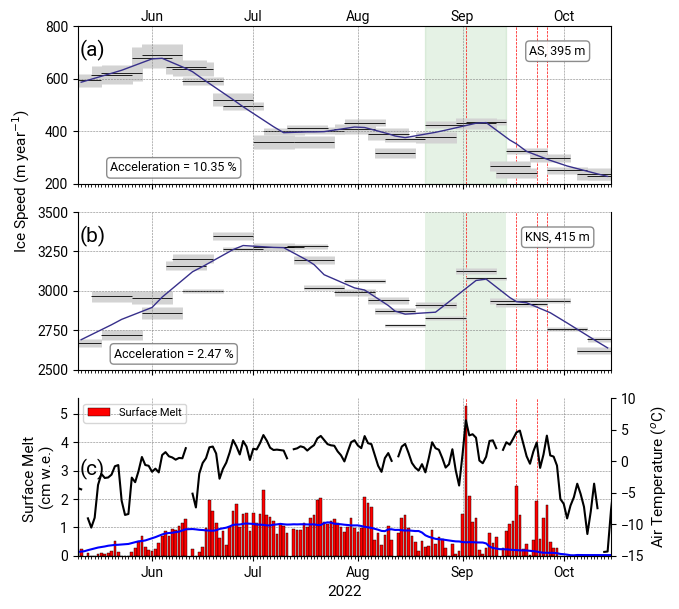

In [10]:
from datetime import datetime, timedelta

tick_fontsize = 10
label_fontsize = 11
title_fontsize = 11
mpl.rcParams['font.family'] = 'Roboto'
plt.rcParams['axes.linewidth'] = 0.8
plt.rc('xtick', labelsize=tick_fontsize)
plt.rc('ytick', labelsize=tick_fontsize)
plt.rc('axes', labelsize=label_fontsize)
plt.rc('axes', titlesize=title_fontsize)
plt.rc('legend', fontsize=label_fontsize)    # legend fontsize
plt.rc('figure', titlesize=title_fontsize)  # fontsize of the figure title
plt.rcParams['axes.facecolor'] = 'None'
plt.rcParams['savefig.facecolor']='w'
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)

fig = plt.figure()
spec = gridspec.GridSpec(ncols=1, nrows=3, hspace=0.18)

# Isunguata sermia ############################################################
ax = fig.add_subplot(spec[0])
ax.set_facecolor('none')

ax.errorbar(AS_ROI.index, AS_ROI['S'], AS_ROI['STD'], ls='none', ecolor='lightgrey', elinewidth=29.5, zorder=-4)
ax.errorbar(AS_ROI.index, AS_ROI['S'], xerr = timedelta(days=6), ecolor='black', elinewidth=0.6, ls='none', zorder=-2)
ax.plot(AS_ROI.index, AS_ROI['lowess'], color='#372F8B', linewidth=1.0, zorder=2, clip_on=False)
ax.axvspan(melt_start, melt_end, color='g', alpha=0.1, zorder=-6)

yticks = [200, 400, 600, 800]
ax.set_yticks(yticks)
ax.set_xlim(year_start, year_end)
ax.set_ylim(yticks[0], yticks[-1])

myFmt = mdates.DateFormatter('')
ax.xaxis.set_minor_formatter(myFmt)
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
majorFmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_formatter(majorFmt)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.axvline(pd.to_datetime('2022-09-02'), color='r', linewidth=0.5, linestyle='--', zorder=-5)
ax.axvline(pd.to_datetime('2022-09-17'), color='r', linewidth=0.5, linestyle='--', zorder=-5)
ax.axvline(pd.to_datetime('2022-09-23'), color='r', linewidth=0.5, linestyle='--', zorder=-5)
ax.axvline(pd.to_datetime('2022-09-26'), color='r', linewidth=0.5, linestyle='--', zorder=-5)


# Show the tick labels
ax.xaxis.set_tick_params(labeltop=True)
ax.xaxis.set_tick_params(labelbottom=False)
ax.tick_params(axis='x', which='major', pad=-2)

#ax.spines[['right']].set_visible(False)
ax.grid(color='grey', linestyle='--', linewidth=0.4, zorder=-5)
ax.text(0.9, 0.84, "AS, 395 m", transform=ax.transAxes, ha="center", va="center", size=9, bbox=bbox_props)
ax.text(0.004, 0.81, '(a)', transform=ax.transAxes, fontsize=15)


textstr = 'Acceleration = %.2f %%' % AS_ROI['acceleration'].values[0]
ax.text(0.18, 0.1, textstr, transform=ax.transAxes, ha="center", va="center", size=9, bbox=bbox_props)


# russell ############################################################
ax1 = fig.add_subplot(spec[1])
ax1.set_facecolor('none')

ax1.errorbar(KNS_ROI.index, KNS_ROI['S'], KNS_ROI['STD'], ls='none', ecolor='lightgrey', elinewidth=29.5, zorder=-4)
ax1.errorbar(KNS_ROI.index, KNS_ROI['S'], xerr = timedelta(days=6), ecolor='black', elinewidth=0.6, ls='none', zorder=-2)
ax1.plot(KNS_ROI.index, KNS_ROI['lowess'], color='#372F8B', linewidth=1.0, zorder=2, clip_on=False)
ax1.axvspan(melt_start, melt_end, facecolor='g', alpha=0.1, zorder=-6)

yticks = [2500, 2750, 3000, 3250, 3500]
ax1.set_yticks(yticks)
ax1.set_xlim(year_start, year_end)
ax1.set_ylim(yticks[0], yticks[-1])

myFmt = mdates.DateFormatter('')
ax1.xaxis.set_minor_formatter(myFmt)
ax1.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
majorFmt = mdates.DateFormatter('%b')
ax1.xaxis.set_major_formatter(majorFmt)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.set_xticklabels([])
ax1.spines[['top']].set_visible(False)
ax1.set_ylabel('Ice Speed (m year$^{-1}$)', y=1.2)

ax1.grid(color='grey', linestyle='--', linewidth=0.4, zorder=-5)
ax1.axvline(pd.to_datetime('2022-09-02'), color='r', linewidth=0.5, linestyle='--', zorder=-5)
ax1.axvline(pd.to_datetime('2022-09-17'), color='r', linewidth=0.5, linestyle='--', zorder=-5)
ax1.axvline(pd.to_datetime('2022-09-23'), color='r', linewidth=0.5, linestyle='--', zorder=-5)
ax1.axvline(pd.to_datetime('2022-09-26'), color='r', linewidth=0.5, linestyle='--', zorder=-5)


ax1.text(0.9, 0.84, "KNS, 415 m", transform=ax1.transAxes, ha="center", va="center", size=9,
        bbox=bbox_props)

ax1.text(0.004, 0.81, '(b)', transform=ax1.transAxes, fontsize=15)


textstr = 'Acceleration = %.2f %%' % KNS_ROI['acceleration'].values[0]
ax1.text(0.18, 0.1, textstr, transform=ax1.transAxes, ha="center", va="center", size=9, bbox=bbox_props)#

# ## COSIPY ############################################################
ax5 = fig.add_subplot(spec[2])
ax5.set_facecolor('none')


ax5.bar(time_cosipy, surfm*100, color='r', zorder=2, edgecolor='k', linewidth=0.3, label='Surface Melt')
ax5.set_xlim(year_start, year_end)
ax5.set_ylabel('Surface Melt \n(cm w.e.)')
ax5.set_yticks([0, 1, 2, 3, 4, 5])

ax5.plot(surfM_historic.index, surfM_historic*100, color='blue', linewidth=1.5, zorder=3)

myFmt = mdates.DateFormatter('')
ax5.xaxis.set_minor_formatter(myFmt)
ax5.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax5.grid(color='grey', linestyle='--', linewidth=0.4, zorder=-5)
ax5.axvline(pd.to_datetime('2022-09-02'), color='r', linewidth=0.5, linestyle='--', zorder=-5)
ax5.axvline(pd.to_datetime('2022-09-17'), color='r', linewidth=0.5, linestyle='--', zorder=-5)
ax5.axvline(pd.to_datetime('2022-09-23'), color='r', linewidth=0.5, linestyle='--', zorder=-5)

majorFmt = mdates.DateFormatter('%b')
ax5.xaxis.set_major_formatter(majorFmt)
ax5.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax5.legend(loc='upper left', fontsize=8)
ax5.spines[['right', 'top']].set_visible(False)
ax5.set_xlabel('2022')

ax5b = ax5.twinx()
ax5b.plot(time_cosipy, T2-273.15, c='k', label='T2')
ax5b.set_ylim(-15,10)
ax5b.set_ylabel('Air Temperature ($^{o}$C)')
ax5b.set_yticks([-15,-10,-5,0,5,10])
ax5b.spines[['top']].set_visible(False)

ax5.text(0.004, 0.51, '(c)', transform=ax5.transAxes, fontsize=15)


width = 6.88 
height = width/1
fig.set_size_inches(width, height)
plt.show()
fig.savefig('fig3_MTG_velocities.jpg', dpi=300, bbox_inches='tight')
